# Parameter choosing AT - Daten und KI

In [2]:
# Importando tudo que já está fixo:

# Data processing
import json
import numpy as np
import pandas as pd
import re


# Topic model
import umap
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

# Dimension reduction
from umap import UMAP


# Countvectorizer (para stopwords)
from sklearn.feature_extraction.text import CountVectorizer


# Text preprocessiong # vou usar stopwords originais
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.corpus import stopwords

#getting german stopwords:
german_stop_words = stopwords.words('german')


## For UMAP Analisys:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
sns.set()


from sentence_transformers import SentenceTransformer

# para montar as combinacoes:
from itertools import product

# Para a matrix 
from sklearn.metrics.pairwise import cosine_similarity

# Topic Coherence:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

## Functions to clean data:

def replace_char(x):
  return re.sub('[^a-zA-Z\süöäß]', '', x)


def clean_corpus(s):
    s = s.apply(lambda x: x.lower() if isinstance(x, str) else x)     # tolower:
    idx = s.apply(lambda x: isinstance(x, str))                       # Criar um índice booleano para filtrar os valores não-texto
    s = s.drop(idx[~idx].index)                                       # Remover os valores não-texto
    s = s.apply(replace_char)                                         # remover as partes de palavras que nao sao caracteres ou espacos
    idx = s.apply(lambda x: len(x) < 2)                               # Criar um índice booleano para filtrar os elementos com comprimento menor que 2
    s = s.drop(idx[idx].index)                                        # Remover os elementos com comprimento menor que 2
    idx = s.apply(lambda x: x == '')                                  # Criar um índice booleano para filtrar os elementos vazios
    s = s.drop(idx[idx].index)                                        # Remover os elementos vazios
    
    return s

def calculuate_coherence_score(topic_model):  
  #variable
  topic_words = topic_words = [[words for words, _ in topic_model.get_topic(topic) if words!=''] 
               for topic in range(len(set(topics))-1)]
  vectorizer = topic_model.vectorizer_model
  tokenizer = vectorizer.build_tokenizer()
  #dictionary
  tokens = [doc.split() for doc in docs]
  dictionary = corpora.Dictionary(tokens)
  corpus = [dictionary.doc2bow(token) for token in tokens]


  coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
  coherence = coherence_model.get_coherence()

  
  return coherence

# Abrindo o arquivos
df_original = pd.read_csv("C:\\Users\\JVoigt\\OneDrive - Universität für Weiterbildung Krems\\Dokumente\\Python Scripts\\Champions_Workshop\\concepts_last.csv",
                           sep = ';')

# creating parameters combinations

n = [5, 7, 10, 20]  # n_neighbors
d = [0.0, 0.1, 0.25]   # min_dist
c = [10, 15, 20, 25, 30] #min_cluster
s = [c_i/4 for c_i in c]  # min_sample

combinations = list(product(n, d, c, s))

combinations = [comb for comb in combinations if comb[3] == comb[2]/4]

c:\python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JVoigt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\JVoigt\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JVoigt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Fazendo a lista de documentos:
tinicio = 'austrian_speeches'
docs = df_original['concept']
docs = clean_corpus(docs).to_list()

### início do loop: rodando todas as combinacoes de parâmetros para fazer o meu modelo:

df = pd.DataFrame({'parameters': [],'n_neighbors': [], 'min_dist': [], 'min_cluster' : [], 
                      'min_sample': [], 'topic_coherence': [], 'nr_topics': [], 'avg_similarity' : [], 'topics': []})


for comb in combinations:
    n_neighbors = comb[0]
    min_dist = comb[1]
    min_cluster = comb[2]
    min_sample = int(comb[3])

    try: 
        umap_model  = UMAP(n_neighbors=n_neighbors, 
                            min_dist = min_dist,
                            n_components=5, 
                            metric='cosine', random_state=42)
    
        hdbscan_model = HDBSCAN(min_cluster_size=min_cluster, 
                                min_samples = min_sample, 
                                metric='euclidean', 
                                prediction_data=True)
        
        vectorizer_model = CountVectorizer(stop_words=german_stop_words) #german_stop_words original

        topic_model = BERTopic(language = "german", vectorizer_model=vectorizer_model, 
                            umap_model=umap_model, 
                            hdbscan_model=hdbscan_model).fit(docs)

        topics, probs = topic_model.fit_transform(docs)         # Cada topic modeling está demorando 25 segundos

        # Matrix de similaridade:

        matrixA = cosine_similarity(np.array(topic_model.topic_embeddings_)[1:, :])
        avg_similarity = np.average(matrixA)
        labels = (topic_model.get_topic_info().sort_values("Topic", ascending=True).Name)[1:]
        nr_topics = len(labels)
        labels = labels.str.cat(sep='; ')
        title = tinicio + 'n_neighbors = ' + str(n_neighbors) + ' min_dist = ' + str(min_dist) + ' min_cluster = ' + str(min_cluster) + ' min_sample = ' + str(min_sample)
        
        #coherence score:
        cs = calculuate_coherence_score(topic_model)

        df_temp = pd.DataFrame({'parameters': [title],
                                'n_neighbors': [n_neighbors],
                                'min_dist': [min_dist],
                                'min_cluster' : [min_cluster],
                                'min_sample': [min_sample], 
                                'topic_coherence': [cs],
                                'nr_topics': [nr_topics],
                                'avg_similarity' : [avg_similarity],
                                'topics': [labels]})
        pd.DataFrame({'parameters': [], 
                        'nr_topics': [], 'avg_similarity' : [], 'topics': []})


        df = pd.concat([df, df_temp])
        print('ok')
    except:
        print(n_neighbors, min_dist, min_cluster, min_sample, ' not valid')
        continue

titulo_df_avg_similarity = 'df_avg_similarity_coerence_coeficient_' + tinicio + '.csv'    
df.to_csv(titulo_df_avg_similarity, sep = ';', index = False, )

## 1.1 Olhando os resultados

In [8]:
# reabrindo o arquivo, caso eu tenha fechado
tinicio = 'austrian_speeches'
titulo_df_avg_similarity = 'df_avg_similarity_coerence_coeficient_' + tinicio + '.csv'   
df = pd.read_csv(titulo_df_avg_similarity, sep=';')

df1 = df
df1 = df1.sort_values('avg_similarity')
df1.head(1)

,parameters,n_neighbors,min_dist,min_cluster,min_sample,topic_coherence,nr_topics,avg_similarity,topics
41,austrian_speechesn_neighbors = 10 min_dist = 0...,10.0,0.25,20.0,5.0,0.413625,4.0,0.781106,0_waldfonds_forstwirtschaft_waldfondgesetz_tra...


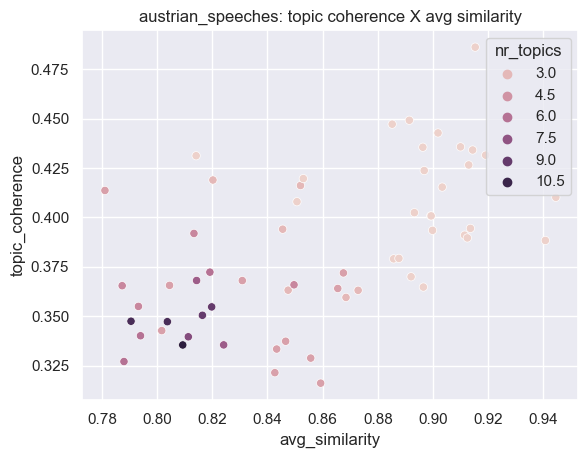

In [9]:
# Verificando a dispersao:

import seaborn as sns
import matplotlib.pyplot as plt

# criando o gráfico de dispersão
sns.scatterplot(data=df1, x='avg_similarity', y='topic_coherence', hue='nr_topics')

# adicionando labels de eixo
plt.xlabel('avg_similarity')
plt.ylabel('topic_coherence')

# adicionando título
titulo_do_plot = tinicio + ": topic coherence X avg similarity"
plt.title(titulo_do_plot)

# exibindo o gráfico
plt.show()

### Segunda parte

In [10]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Modificar aqui também!

# reabrindo o arquivo, caso eu tenha fechado
#df1 = pd.read_csv(titulo_df_avg_similarity, sep=';')

df1 = df1.query('topic_coherence > 0.325 & avg_similarity < 0.80 & nr_topics > 6')
df1 = df1.reset_index()

combinations = []

for i in range(0,len(df1)):
    n = df1.iloc[i, 2]  # linha coluna
    d = df1.iloc[i, 3]
    c = int(df1.iloc[i, 4])
    s = int(df1.iloc[i, 5])
    
    com = [(n, d, c, s)]

    combinations.extend(com)

for comb in combinations:
    print(comb)

(7.0, 0.0, 10, 2)


In [13]:
docs = df_original['concept']
docs = clean_corpus(docs).to_list()

n_neighbors = 7
min_dist = 0.0
min_cluster = int(10)
min_sample = int(2)

umap_model  = UMAP(n_neighbors=n_neighbors,
                   min_dist = min_dist,
                   n_components=5, 
                   metric='cosine', random_state=42)

hdbscan_model = HDBSCAN(min_cluster_size=min_cluster, min_samples = min_sample, metric='euclidean', prediction_data=True)

vectorizer_model = CountVectorizer(stop_words=german_stop_words) #german_stop_words original

topic_model = BERTopic(language = "german", vectorizer_model=vectorizer_model, umap_model=umap_model, hdbscan_model=hdbscan_model).fit(docs)
topics, probs = topic_model.fit_transform(docs)

# Dataframe with representative examples:

df_rep = topic_model.get_document_info(docs)
df_rep = df_rep.query('Representative_document == True')

In [15]:
df_rep.head(1)
df_rep.to_csv('examples_speeches.csv', sep = ';', index = False, )